In [1]:
import os
import numpy  as np 
import warnings
warnings.filterwarnings("ignore")

import random
from random import seed
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LSTM, Reshape
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-10-25 08:28:40.222001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-25 08:28:40.222098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-25 08:28:40.358111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


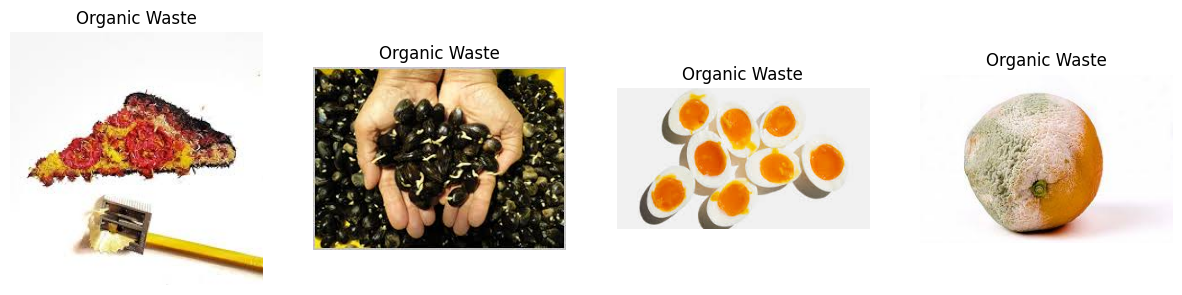

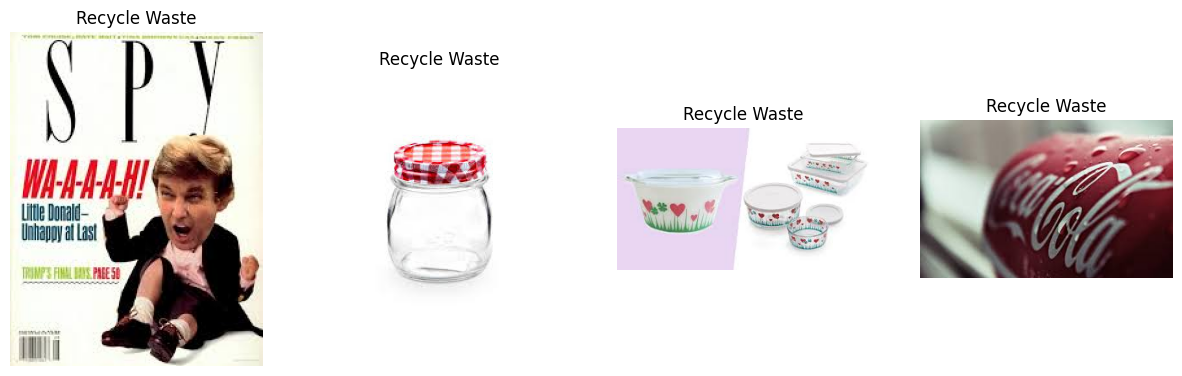

In [4]:
def plot_random_images(dataset_dir, category, num_images=4):
    # Path to the specified category directory
    category_dir = os.path.join(dataset_dir, 'TRAIN', category)
    
    # Get the list of image file names in the category directory
    image_files = os.listdir(category_dir)
    
    # Select num_images random images from the category directory
    random_images = random.sample(image_files, num_images)
    
    # Plot the random images
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(random_images):
        # Load the image
        image_path = os.path.join(category_dir, image_name)
        image = Image.open(image_path)
        
        # Plot the image
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(("Organic" if category == 'O' else "Recycle") + " Waste")  # Set the title for each image
        plt.axis('off')
    
    plt.show()

# Example usage: plot 4 random images from 'O' (Organic) and 'R' (Recyclable) categories
dataset_dir = '/kaggle/input/waste-classification-data/DATASET'
plot_random_images(dataset_dir, 'O', num_images=4)
plot_random_images(dataset_dir, 'R', num_images=4)

In [5]:
train_directory = '/kaggle/input/waste-classification-data/DATASET/TRAIN'
test_directory = '/kaggle/input/waste-classification-data/DATASET/TEST'

In [7]:
train_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

validation_data_generator = ImageDataGenerator(
    #rescale=1./255,
    preprocessing_function=preprocess_input,
    validation_split=0.2,
)

test_data_generator = ImageDataGenerator(
    #rescale = 1./255,
    preprocessing_function=preprocess_input
)

In [8]:
train_generator = train_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="training",
    seed = 43
)

Found 18052 images belonging to 2 classes.


In [9]:
validation_generator = validation_data_generator.flow_from_directory(
    train_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True,
    subset="validation",
    seed = 43
)

Found 4512 images belonging to 2 classes.


In [10]:
test_generator = test_data_generator.flow_from_directory(
    test_directory,
    target_size=(150,150),
    class_mode='binary',
    batch_size=128,
    shuffle = True
)

Found 2513 images belonging to 2 classes.


In [11]:
print(f"Number of images in the training set: {train_generator.n}")
print(f"Number of images in the validation set: {validation_generator.n}")
print(f"Number of images in the testing set: {test_generator.n}")

Number of images in the training set: 18052
Number of images in the validation set: 4512
Number of images in the testing set: 2513


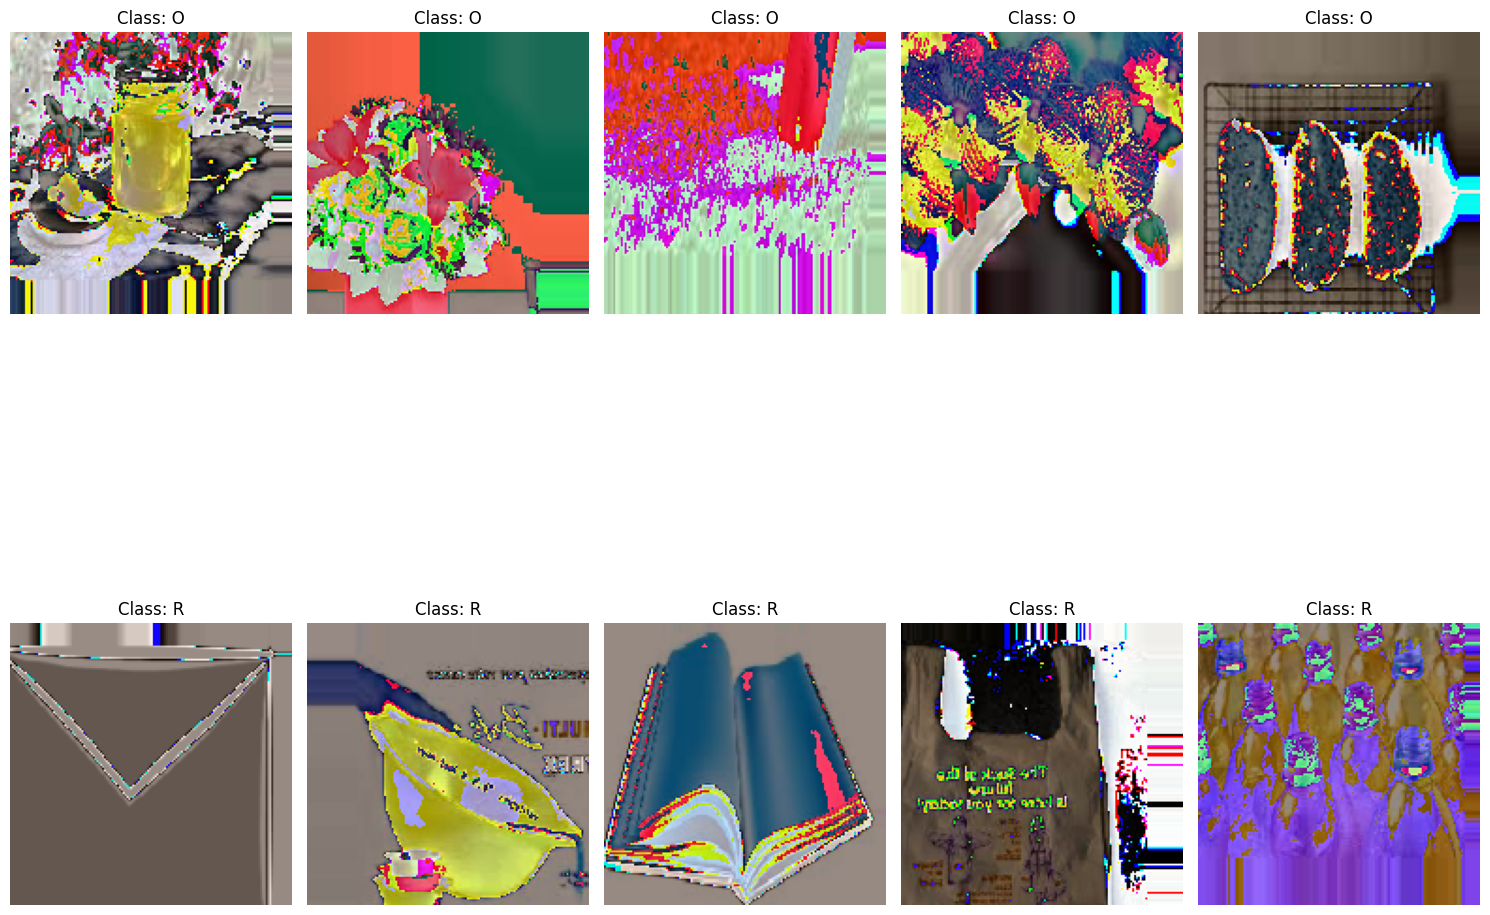

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Function to plot and display augmented images
def plot_augmented_images(generator, class_names, n_images_per_class=5):
    plt.figure(figsize=(15, 15))

    # Loop through each class
    for class_idx, class_name in enumerate(class_names):
        generator.reset()  # Reset the generator to start from the beginning
        images, labels = next(generator)  # Get a batch of images and labels

        # If the labels are 1D (binary classification), reshape them
        if len(labels.shape) == 1:
            labels = np.eye(len(class_names))[labels.astype(int)]  # Convert 1D labels to one-hot

        # Find the images that belong to the current class
        class_images = images[np.where(labels[:, class_idx] == 1)]

        # Plot a few images for the current class
        for i in range(min(n_images_per_class, len(class_images))):
            plt.subplot(len(class_names), n_images_per_class, class_idx * n_images_per_class + i + 1)
            plt.imshow(class_images[i].astype(np.uint8))  # Display the image
            plt.title(f"Class: {class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

# Plot a few augmented images for each class
plot_augmented_images(train_generator, class_names)

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the ResNet50 model, excluding the top layers
core = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
core.trainable = False  # Freeze the ResNet50 layers to prevent training

# Define the custom model
model = Sequential([
    core,
    Conv2D(64, (2, 2), activation='relu'),  # 64 filters with a 2x2 window
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Reshape((1, -1)),
    LSTM(50, return_sequences=False),  # LSTM layer with 50 units
    Dropout(0.5),
    Dense(25, activation="relu"),
    Dense(2, activation="softmax")  # Output layer for binary classification
])

# Compile the model using sparse_categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# Set up early stopping
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True)

# Set up model checkpointing
checkpoint_path = "model_checkpoint_resnet50_conv_pool.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Fit the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[earlystopping, checkpoint]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.8360 - loss: 0.3689
Epoch 1: val_accuracy improved from -inf to 0.94592, saving model to model_checkpoint_resnet50_conv_pool.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 142s 867ms/step - accuracy: 0.8364 - loss: 0.3683 - val_accuracy: 0.9459 - val_loss: 0.1606
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.9282 - loss: 0.2035
Epoch 2: val_accuracy improved from 0.94592 to 0.95346, saving model to model_checkpoint_resnet50_conv_pool.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 123s 828ms/step - accuracy: 0.9282 - loss: 0.2035 - val_accuracy: 0.9535 - val_loss: 0.1384
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.9336 - loss: 0.1776
Epoch 3: val_accuracy did not improve from 0.95346
142/142 ━━━━━━━━━━━━━━━━━━━━ 122s 819ms/step - accuracy: 0.9336 - loss: 0.1776 - val_accuracy: 0.9384 - val_loss: 0.1611
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 746

In [27]:
evaluation = model.evaluate(test_generator)
print(f'test Loss: {evaluation[0]:.4f}')
print(f'test Accuracy: {evaluation[1] * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 541ms/step - accuracy: 0.9028 - loss: 0.2176
test Loss: 0.2452
test Accuracy: 90.01%


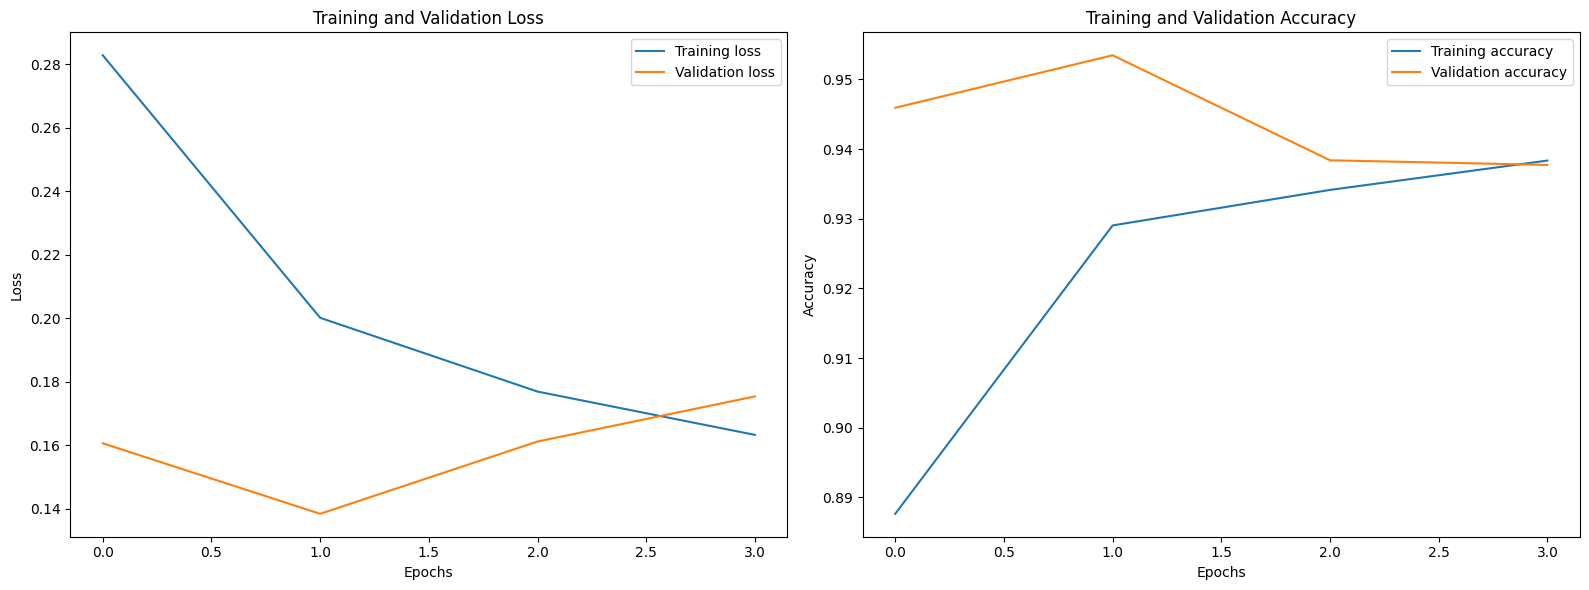

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(12, 5)):
    num_metrics = len(metrics)
    plt.figure(figsize=figsize)
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, num_metrics, i)
        plt.plot(history.epoch, history.history[metric], label='Training ' + metric)
        plt.plot(history.epoch, history.history['val_' + metric], label='Validation ' + metric)
        plt.title('Training and Validation ' + metric.capitalize())
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(history, metrics=['loss', 'accuracy'], figsize=(16, 6))


In [29]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

In [34]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)  # Just rescale for validation


In [35]:
# Unfreeze the top ResNet layers
for layer in core.layers[-10:]:
    layer.trainable = True


In [37]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)

In [43]:
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Get the class labels from the training generator
train_labels = train_generator.classes

# Compute the class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)

# Convert the output to a dictionary as required by the Keras fit function
class_weights_dict = dict(enumerate(class_weights))

# Set up early stopping to stop training after 2 epochs with no improvement
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=2, restore_best_weights=True, verbose=1)

# Set up model checkpoint to save the best model
checkpoint_path = "model_checkpoint_resnet50_conv_pool.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Fit the model with class weights and callbacks
history = model.fit(train_generator, 
                    epochs=50, 
                    validation_data=validation_generator, 
                    class_weight=class_weights_dict,  # Pass the computed class weights
                    callbacks=[earlystopping, checkpoint])

# After training, print the final accuracy
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']

print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")


Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.9537 - loss: 0.1464
Epoch 1: val_accuracy improved from -inf to 0.94614, saving model to model_checkpoint_resnet50_conv_pool.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 138s 929ms/step - accuracy: 0.9537 - loss: 0.1464 - val_accuracy: 0.9461 - val_loss: 0.1627
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.9635 - loss: 0.1075
Epoch 2: val_accuracy improved from 0.94614 to 0.94880, saving model to model_checkpoint_resnet50_conv_pool.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 123s 825ms/step - accuracy: 0.9635 - loss: 0.1075 - val_accuracy: 0.9488 - val_loss: 0.1521
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.9718 - loss: 0.0856
Epoch 3: val_accuracy improved from 0.94880 to 0.95966, saving model to model_checkpoint_resnet50_conv_pool.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 122s 824ms/step - accuracy: 0.9718 - loss: 0.0857 - val_accuracy: 0.9597 - val_loss: 0.1300
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━

In [45]:
# Assuming you have a test_generator defined
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.9125 - loss: 0.2828
Test Accuracy: 0.9121


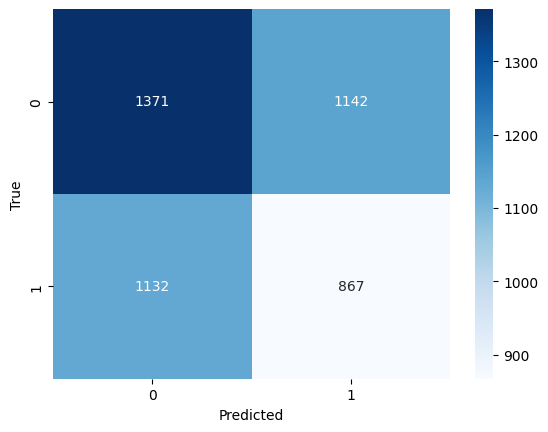

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_true_labels, val_predictions_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [47]:
val_predictions = model.predict(validation_generator)

# Convert predictions to class labels (binary format, not one-hot)
# If the output is softmax (2 classes), pick the index with the highest probability
val_predictions_binary = np.argmax(val_predictions, axis=1)

# Get true labels
val_true_labels = validation_generator.classes

# Now compute precision, recall, and F1 score using sklearn metrics
precision = precision_score(val_true_labels, val_predictions_binary)
recall = recall_score(val_true_labels, val_predictions_binary)
f1 = f1_score(val_true_labels, val_predictions_binary)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Alternatively, use classification_report for a detailed report
print(classification_report(val_true_labels, val_predictions_binary))


36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 358ms/step
Precision: 0.4392
Recall: 0.4427
F1 Score: 0.4410
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      2513
           1       0.44      0.44      0.44      1999

    accuracy                           0.50      4512
   macro avg       0.50      0.50      0.50      4512
weighted avg       0.50      0.50      0.50      4512

